Spring 2022 Grading Script

Import Libraries and Functions

In [1]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from grading_functions import *
from matplotlib import pyplot as plt

Import Files

In [2]:
"""grades is from Gradescope, 
roster is the current student list from egrades, 
webwork is the homework total downloaded from Gauchospace"""
grades = pd.read_csv("Grades.csv")
roster = pd.read_csv("Roster.csv")
webwork = pd.read_csv("Webwork.csv", na_values=["-"])

Creating a Quiz Max Points List. 
The list will be used later to adjust quiz grades for students who were sick and missed section. 

In [3]:
#Total Quiz Points Column
quiz_point_max_columns = [name for name in grades.columns if "Max Points" in name and "quiz" in name.lower()]
#grades["QPTot"] = grades.apply(lambda row: sum([row[name] for name in quiz_point_max_columns]), axis=1)
quiz_max_points = grades[quiz_point_max_columns].iloc[1].values

1 Renaming columns in all three dataframes for compatability and ease of reading

2 Deleting garbage columns from Gradescope's list

3 Slimming down the egrades roster and webwork roster to include only what we need for student identification

In [4]:
#Renameing "Perm #" to "SID" in Egrades, which may not even be necessary. 
roster.rename(columns = {"Perm #": "SID"}, inplace = True)

#Renaming the same and the Homework column in Webwork
webwork.rename(columns = {"ID number": "SID"}, inplace = True)
webwork.rename(columns = {"External tool:Webwork (Real)": "HWT"}, inplace = True)

#Deleting Garbage Columns
junk_column_indices = [i for i, column in enumerate(grades.columns) \
                       if "Max Points" in column or "Submission Time" in column \
                       or "Lateness" in column or column == "section_name" or column == "Email"]
grades.drop(grades.columns[junk_column_indices], axis=1, inplace=True)

#Renaming Columns: Homework and quizzes (In grades df)
quiz_column_names = [name for name in grades.columns if "quiz" in name.lower()]
grades.rename(columns = {name: "Quiz"+" "+str(i+1) for i, name in enumerate(quiz_column_names)}, inplace = True)

#Roster and Webwork Operations
roster = roster[["Enrl Cd", "SID"]]
webwork = webwork[["SID", "HWT"]]

Merging the versions of Midterm 1 into a new column and dropping the version columns

In [5]:
midterm1_version_list = ["Midterm 1 Gold", "Midterm 1 Blue"]
grades["Midterm 1"] = grades.apply(version_merger, 
                                   version_list=midterm1_version_list, 
                                   axis=1)
#grades["Midterm 1"] = grades.apply(lambda row: version_merger(row, midterm1_version_list), axis=1)
grades.drop(columns=midterm1_version_list, axis=1, inplace=True)

Debugging code for the upcomming dataframe merge with a description. 

Merge the Three Dataframes

In [6]:
#merging Gradescope and Egrades
grades_merge_one = pd.merge(grades, roster, on="SID", how ="right")
#merging the result and Webwork
grades_for_submission = pd.merge(webwork, grades_merge_one, on="SID", how ="right")

More pruning of columns - I'm not sure if this is necessary because it looks like the same was done for the Gradescope file. Maybe it's also done for the egrades list - and this could be done at the beginning. 

In [7]:
#Pruning more columns from general roster
junk_column_indices = [i for i, column in enumerate(grades_for_submission.columns) \
                       if "Pronouns" in column or "Lateness" in column \
                       or column == "section_name" or column == "Email"]
grades_for_submission.drop(grades_for_submission.columns[junk_column_indices], axis=1, inplace=True)

Scaling the Midterm Scores to make them out of 100. Their column names are also shortened to make the spreadsheet easier to read when you open the file. 

In [8]:
#Scaling the Midterms
grades_for_submission["M1"] = np.round(grades_for_submission["Midterm 1"]*4, decimals=1)
grades_for_submission["M2"] = np.round(100*grades_for_submission["Midterm 2"]/23, decimals=1)
grades_for_submission["M3"] = np.round(100*grades_for_submission["Midterm 3"]/40, decimals=1)
#Drop Midterm Point Columns
grades_for_submission.drop(columns=["Midterm 1", "Midterm 2", "Midterm 3"], axis=1, inplace=True)

Adjusting Quiz Grades to account for excused absences. 

In [9]:
#Missing Quiz Corrections
#Trevor's cover left all of the quizzes out on a table in the tea room, 
#so here is a list of all of his students. 
trevor_df = pd.read_csv("Excused Tests/Trevor's Students.csv")
trevor_students = list(trevor_df["SID"])

Constructing a dataframe to hold information in the place where a student has an excused abscence from a quiz: The row/column corresponding to that quiz score for that student has a tuple. Students with excused absences have a (0,max_points) tuple and every other entry has a (score, 0) tuple. The quiz average column of the dataframe is then computed using these tuples: We sum over the scores of the first parts (giving the total quiz points earned) and divide by the total quiz points minus the max_points values for excused quizzes. This computes the same total as if the students had their excused quizzes replaced by their quiz average. 

In [10]:
missing_quiz_matrix = grades_for_submission[["SID"]].copy()
#excused_list_points
n=len(quiz_max_points)
for i in range(1,n+1):
    quiz_df = pd.read_csv("Excused Tests/Quiz "+str(i)+" Excused Students.csv")
    excused_list = list(quiz_df["SID"])
    missing_quiz_matrix["Quiz "+str(i)+"-"] = grades_for_submission.fillna(0).apply(quiz_tuple_function, 
                                                                                    excused_list = excused_list, 
                                                                                    trevor_students = trevor_students, 
                                                                                    i = i, 
                                                                                    quiz_max_points = quiz_max_points, 
                                                                                    axis=1)

    

#Computing the Quiz Total (average percentage score)
grades_for_submission["QT"] = missing_quiz_matrix.apply(quiz_average_calculator, 
                                                        i = i, 
                                                        quiz_max_points = quiz_max_points, 
                                                        axis=1)

#Just for fun, this replaces the excused missing quiz score with their total percent of the max points so if you add the
#entries in Excel, you should get the same quiz total for these students. I just verified this, and they agree up to a
#rounding error. 
for i in range(1,len(quiz_max_points)+1):
    quiz_df = pd.read_csv("Excused Tests/Quiz "+str(i)+" Excused Students.csv")
    excused_list = list(quiz_df["SID"])
    grades_for_submission["Quiz "+str(i)] = grades_for_submission.apply(quiz_missing_points_allocator, 
                                                                        quiz_max_points = quiz_max_points, 
                                                                        i = i, 
                                                                        excused_list = excused_list, 
                                                                        trevor_students = trevor_students, 
                                                                       axis=1)

Now columns are everywhere! This block sorts the columns and puts the key ones in the front. 
The dataframe with grades on it is also shortened from grades_for_submission to gfs since I copied it. 
The copy was probably not necessary, but I was new to the practice. 

In [11]:
#Let's sort the columns and shorten the name of the data set (so gfs will be grades_for_submission sorted)
gfs_copy = grades_for_submission.copy()
#first_columns = ["First Name", "Last Name", "Enrl Cd", "SID", "Grade", "ClassLevel", "Major1", "Major2"]
first_columns = ["First Name", "Last Name", "Enrl Cd", "SID"]
gfs_copy.drop(first_columns, axis=1, inplace=True)
gfs_copy = gfs_copy[sorted(gfs_copy.columns)]
gfs = gfs_copy.copy()
for i, info_col in enumerate(first_columns):
    gfs.insert(i, info_col, grades_for_submission[info_col], True)

Creating a Quiz Total column and an Adjusted Quiz Total column to account for the Quiz Reflections: x% of their missing points should be added, where x is their score on "Q Reflection for Improvement." I also named the grading item "Q Reflections..." instead of "Quiz Reflections" because otherwise the script above would have renamed it something like "Quiz 11." Finally, I commented out the "QT" column definition because I later used it above to compute a percentage that did not count missed quizzes that were excused. 

In [12]:
#Quiz Total Column
quiz_list=["Quiz "+str(i) for i in range(1,len(quiz_column_names)+1)]
#gfs["QT"] = gfs[quiz_list].sum(axis=1)*100/sum(quiz_max_points)
#Adjusting the Quiz Total to include missing points
missing_quiz_point_multiplier = gfs["Q Reflection for Improvement"].fillna(0)/200
gfs["QTA"] = gfs["QT"] + (100-gfs["QT"])*missing_quiz_point_multiplier

Convert the "Final Exam" raw score into a "Final" entry with a percent value. 

In [13]:
final_point_total = 72
gfs["Final"] = np.round(gfs["Final Exam"]*100/final_point_total, decimals=1)

Excused Missing Midterms will be replaced with the final percentage (that was just calculated). 

In [14]:
#Replacing Midterm Entries for Excused Absences (that midterm is replaced w/ the final score)
for i in range(1,4):
    excused_df = pd.read_csv("Excused Tests/Midterm "+str(i)+" Excused Students.csv")
    students_list = list(excused_df["SID"])
    gfs["M"+str(i)] = gfs.apply(lambda row: np.round(missed_exam_replacer(row,
                                                                             students_list, 
                                                                            "M"+str(i), 
                                                                            "Final"), 
                                                    decimals=1),
                                axis=1)

#Final Replacement will be done below because we need to replace the final with the midterm average

Computing the Midterm Average: First as a raw percentage as the average of the two highest midterms, which is congruent with making the third midterm optional. In practice, I added the three, dropped the minimum, and then divided by two. I could not find a way to just "drop the lowest," though I strongly suspect there is a command for this. 

MTA is the adjusted midterm average, with x% of the missing points returned based on the x% completed for the midterm reflections assignment. 

In [15]:
#Two New Midterm Grade Columns (Raw Average and "MT" that drops the lowest midterm) -- I dropped "Raw Average" below
gfs["Raw Midterm Average"] = gfs.apply(lambda row: (row.fillna(0)["M1"]+row.fillna(0)["M2"]+row.fillna(0)["M3"])/3
                                                                     , axis = 1)
gfs["MT"] = gfs.apply(lambda row: (3*row["Raw Midterm Average"] - np.min([row.fillna(0)["M1"],row.fillna(0)["M2"],
                                                                          row.fillna(0)["M3"]]))/2, axis = 1)
#Adjusting the Midterm Total to include missing points
missing_midterm_point_multiplier = gfs["Exam Reflection for Improvement"].fillna(0)/200
gfs["MTA"] = gfs["MT"] + (100-gfs["MT"])*missing_midterm_point_multiplier
gfs.drop(columns=["Raw Midterm Average"], axis=1, inplace=True)

There were some students who had documented sickness during the final exam. This used the list of SIDs sent to me by my TAs and based on that list, replaced those students' final scores with their adjusted midterm average. 

In [16]:
#Replacing Final Entries for Excused Absences (that midterm is replaced w/ the final score)
final_df = pd.read_csv("Excused Tests/Final Exam Excused Students.csv")
final_missed = list(final_df["SID"])
gfs["Final"] = gfs.apply(lambda row: missed_exam_replacer(row, final_missed, "Final", "MTA"), 
                                axis=1)
#gfs["Final na0"] = gfs["Final"].fillna(0)

Computing the "Grade" and "Letter Grade" columns, now that all of the information is adjusted as intended. 

In [17]:
#Grade Column
gfs["Grade"] = gfs.apply(lambda row: .1*row["QTA"] + .2*row["HWT"] + .4*row["MTA"] + .3*row.fillna(0)["Final"] + 3,
                        axis=1)
    

#Letter Grade Column
gfs["Letter Grade"] = gfs.apply(lambda row: letter_grade_assigner(row), axis=1)

#ordering columns for Egrades Submission and my sanity
first_columns = ["SID", "Enrl Cd", "Letter Grade", "Final", "MTA", "HWT", "QTA"]
temp_columns = gfs[first_columns]
gfs.drop(columns=first_columns, axis=1, inplace=True)
for (i, col_name) in enumerate(first_columns):
    gfs.insert(i, col_name, temp_columns[col_name])

Saving the gfs dataframe as a CSV file. 

In [18]:
#Save gfs df to a file
gfs.to_csv('Grades_python_output.csv', header=True, index=False)

CSV file for Egrades

In [19]:
##Slim Format for Submission
"Enrl Cd", "SID"
gfs_slim = gfs[["Enrl Cd", "SID", "Letter Grade"]]
gfs_slim.to_csv('Roster List Spring 22.csv', header=True, index=False)

List and Plot of Letter Grades

Grade distribution for the whole class
Letter Grade
A     28
A+    54
A-    23
B     45
B+    19
B-     1
C      2
C+     2
C-     3
D      4
D+     2
F     46
Name: Letter Grade, dtype: int64


<AxesSubplot:xlabel='Letter Grade'>

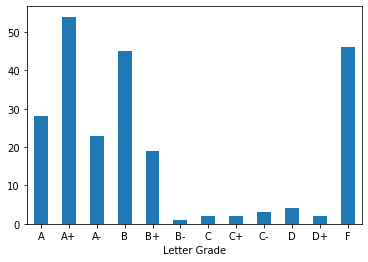

In [20]:
#Letter Grade Distribution
print("Grade distribution for the whole class")
grade_dist = gfs.groupby(by="Letter Grade")
print(grade_dist["Letter Grade"].count())
index = ['F', 'D-', 'D',
         'D+', "C-", "C", "C+", "B-", "B", "B+", "A-", "A", "A+"]
letter_grades = gfs["Letter Grade"].count()
df = pd.DataFrame({'Letter Grade': letter_grades}, index=index)

grade_dist["Letter Grade"].count().plot.bar(rot=0)

Same as above, only restricted to students who either took the final or had a documented medical excuse. 


 
 Grade distribution for only students who took the final
Letter Grade
F               46
D-               0
D                4
D+               2
C-               3
C                2
C+               2
B-               1
B               45
B+              19
A-              23
A               28
A+              54
dtype: int64


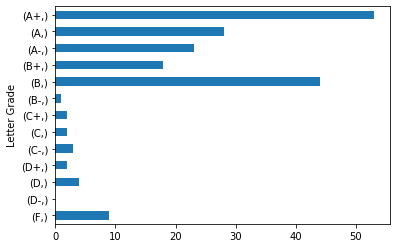

In [21]:
#Letter Grade Distribution  
print("\n","\n","Grade distribution for only students who took the final")
gfs["Letter Grade"] = pd.Categorical(gfs["Letter Grade"], ['F', 'D-', 'D', 
                                                           'D+', "C-", "C", 
                                                           "C+", "B-", "B", 
                                                           "B+", "A-", "A", 
                                                           "A+"], 
                                     ordered = True
                                    )


grade_dist = gfs[["Letter Grade", "Final Exam"]].dropna().groupby(by="Letter Grade")
print(gfs.value_counts(subset=["Letter Grade"])[['F', 'D-', 'D','D+', "C-", "C", 
                                                "C+", "B-", "B", "B+", "A-", "A", "A+"]])
index = ['F', 'D-', 'D',
         'D+', "C-", "C", "C+", "B-", "B", "B+", "A-", "A", "A+"]
letter_grades = gfs["Letter Grade"].count()
df = pd.DataFrame({'Letter Grade': letter_grades}, index=index)

gfs[["Letter Grade", "Final Exam"]].dropna().value_counts(subset=["Letter Grade"])[['F', 'D-', 'D',
         'D+', "C-", "C", "C+", "B-", "B", "B+", "A-", "A", "A+"]].plot.barh(rot=0)

plt.savefig("Images\Grade Distribution Bar Chart.png")
#grade_dist["Letter Grade"].count().plot.bar(rot=0)

Quantile List for various aspects of the course to get more information, followed by Seaborn Histplots. 

   Percentile    Grade      M1      M2      M3      MT      MTA     QT    QTA  \
0        100%  102.660  100.00  100.00  100.00  100.00  100.000  96.60  98.30   
1         95%  100.315   98.74   97.80   97.50   96.75   98.300  86.20  92.06   
2         90%   98.588   94.00   95.70   95.00   96.00   97.005  81.12  88.75   
3         85%   97.584   92.00   91.30   92.50   93.25   95.790  76.90  87.50   
4         80%   96.100   88.00   89.10   92.34   91.20   94.660  75.00  86.20   
5         75%   95.055   86.00   87.00   90.00   89.40   93.150  72.50  83.75   
6         70%   93.598   78.00   84.07   87.50   86.48   92.225  69.60  82.35   
7         65%   91.603   72.00   82.60   87.50   85.20   91.040  65.50  80.00   
8         60%   90.438   70.00   78.30   85.00   81.63   89.015  62.82  78.75   
9         55%   88.938   66.00   73.90   82.50   78.52   87.570  60.00  76.33   
10        50%   87.560   62.00   69.60   79.35   76.00   85.050  58.10  73.75   
11        45%   86.096   58.

<function matplotlib.pyplot.show(close=None, block=None)>

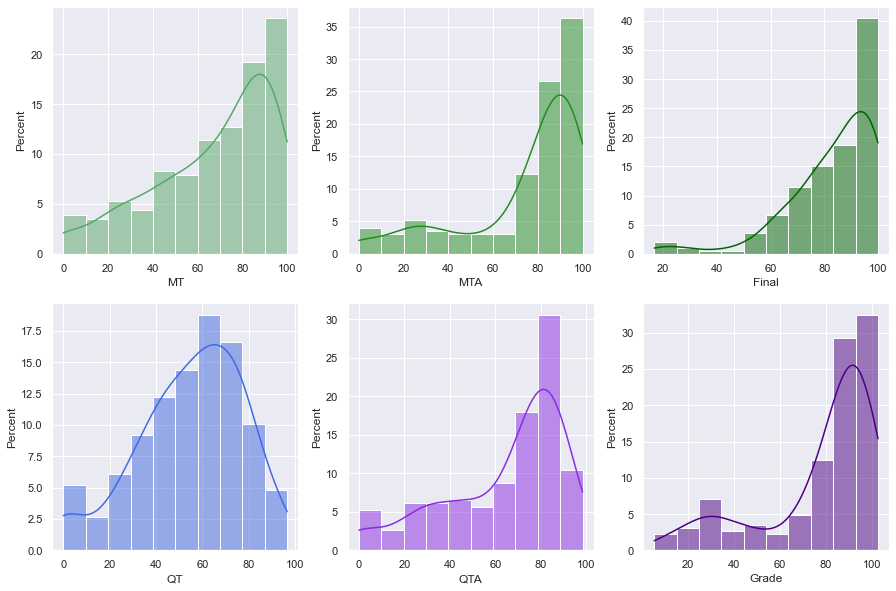

In [22]:
#Making Quantiles for each item
quantiles = pd.DataFrame({
    "Percentile": [str(100-5*n)+"%" for n in range (21)], 
    "Grade": np.quantile([grade for grade in list(gfs["Grade"]) if str(grade) != "nan"], [1-n/20 for n in range(21)]),
    "M1": np.quantile([grade for grade in list(gfs["M1"]) if str(grade) != "nan"], [1-n/20 for n in range(21)]),
    "M2": np.quantile([grade for grade in list(gfs["M2"]) if str(grade) != "nan"], [1-n/20 for n in range(21)]),
    "M3": np.quantile([grade for grade in list(gfs["M3"]) if str(grade) != "nan"], [1-n/20 for n in range(21)]),
    "MT": np.quantile([grade for grade in list(gfs["MT"]) if str(grade) != "nan"], [1-n/20 for n in range(21)]),
    "MTA": np.quantile([grade for grade in list(gfs["MTA"]) if str(grade) != "nan"], [1-n/20 for n in range(21)]),
#    "Raw Midterm Average": np.quantile([grade for grade in list(gfs["Raw Midterm Average"]) if str(grade) != "nan"], [1-n/20 for n in range(21)]),
#    "MTot": np.quantile([grade for grade in list(gfs["Raw Midterm Average"]) if str(grade) != "nan"], [1-n/20 for n in range(21)]),
    "QT": np.quantile([grade for grade in list(gfs["QT"]) if str(grade) != "nan"], [1-n/20 for n in range(21)]),
    "QTA": np.quantile([grade for grade in list(gfs["QTA"]) if str(grade) != "nan"], [1-n/20 for n in range(21)]),
    "HWT": np.quantile([grade for grade in list(gfs["HWT"]) if str(grade) != "nan"], [1-n/20 for n in range(21)]),
    "Final": np.quantile([grade for grade in list(gfs["Final"]) if str(grade) != "nan"], [1-n/20 for n in range(21)]),
})
print(quantiles)


#Plotting Student Scores with Seaborn's histplot
sns.set()
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
sns.set_palette("deep")
#Full Color List (some used below): https://matplotlib.org/stable/gallery/color/named_colors.html
sns.histplot(x=gfs["MT"], kde=True, bins=10, stat='percent', multiple = "dodge", ax=axes[0,0], color="g")
sns.histplot(x=gfs["MTA"], kde=True, bins=10, stat='percent', multiple = "dodge", ax=axes[0,1], color="forestgreen")
sns.histplot(x=gfs["Final"], kde=True, bins=10, stat='percent', multiple = "dodge", ax=axes[0,2], color="darkgreen")
sns.histplot(x=gfs["QT"], kde=True, bins=10, stat='percent', multiple = "dodge", ax=axes[1,0], color="royalblue")
sns.histplot(x=gfs["QTA"], kde=True, bins=10, stat='percent', multiple = "dodge", ax=axes[1,1], color="blueviolet")
sns.histplot(x=gfs["Grade"], kde=True, bins=10, stat='percent', multiple = "dodge", ax=axes[1,2], color="indigo")

plt.savefig("Images\Histplots 1.png")
plt.show

More Seaborn Histplots to contrast performance. 

Midterm Trends
AxesSubplot(0.125,0.536818;0.352273x0.343182)
AxesSubplot(0.125,0.125;0.352273x0.343182)
AxesSubplot(0.547727,0.536818;0.352273x0.343182)
AxesSubplot(0.547727,0.125;0.352273x0.343182)


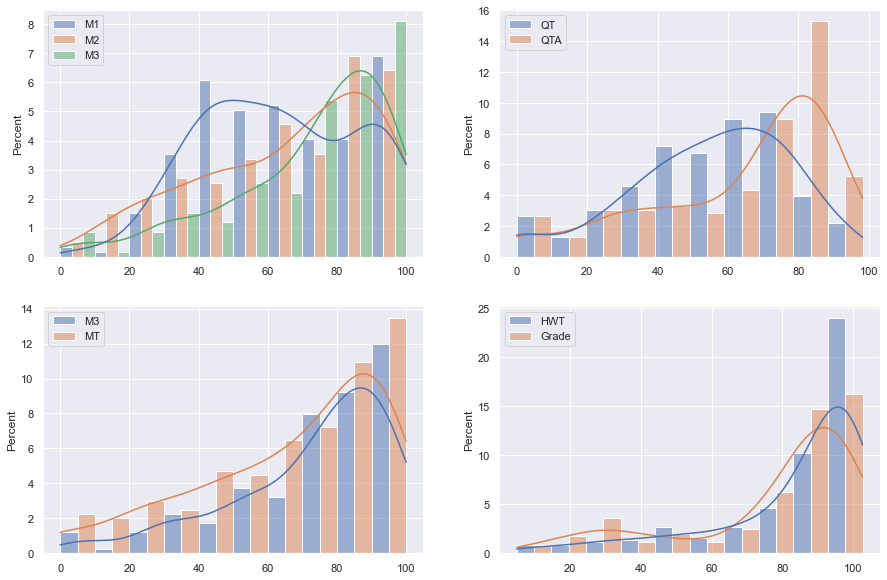

In [23]:
#Midterm Progress in One Vizualization
#sns.displot(gfs["M1"], kde=True, rug=True)
print("Midterm Trends")
sns.set()
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
sns.set_palette("deep")
print(sns.histplot(gfs[["M1", "M2", "M3"]], 
                   kde=True, bins=10, stat="percent", multiple = "dodge", ax=axes[0,0])
     )
print(sns.histplot(gfs[["M3", "MT"]], 
                   kde=True, bins=10, stat="percent", multiple = "dodge", ax=axes[1,0])
     )
print(sns.histplot(gfs[["QT", "QTA"]], 
                   kde=True, bins=10, stat="percent", multiple = "dodge", ax=axes[0,1])
     )
print(sns.histplot(gfs[["HWT", "Grade"]], 
                   kde=True, bins=10, stat="percent", multiple = "dodge", ax=axes[1,1])
     )

plt.savefig("Images\Histplot 2.png")
plt.show()

Miscallaneous Stats (maybe this is bloat)

In [24]:
print("Misc. Stats:")
print(gfs[["M1", "M2", "M3", "MT", "Final"]+["Quiz "+str(i) for i in range(1,9)] + ["QT"]+["HWT"]].describe())

Misc. Stats:
               M1          M2          M3          MT       Final      Quiz 1  \
count  219.000000  202.000000  172.000000  229.000000  193.000000  209.000000   
mean    63.363470   65.690099   72.573837   67.084279   82.863731    4.951675   
std     22.750059   25.441242   22.938776   26.911653   16.941135    0.415111   
min      6.000000    0.000000    2.500000    0.000000   16.700000    0.000000   
25%     44.000000   47.800000   60.000000   49.500000   75.000000    5.000000   
50%     62.000000   69.600000   79.350000   76.000000   87.500000    5.000000   
75%     86.000000   87.000000   90.000000   89.400000   95.800000    5.000000   
max    100.000000  100.000000  100.000000  100.000000  100.000000    5.000000   

           Quiz 2      Quiz 3      Quiz 4      Quiz 5      Quiz 6      Quiz 7  \
count  206.000000  201.000000  201.000000  190.000000  199.000000  179.000000   
mean     1.653883    3.638308    4.179602    1.373158    2.759296    1.654749   
std      1.051